In [2]:
import skdim

import cupy as cp
import numpy as np
from numba import jit

from scipy.spatial.distance import cdist

import time

import matplotlib.pyplot as plt

In [3]:
def pairwise_distance_matrix(points):
    squared_distances = np.sum(points ** 2, axis=1, keepdims=True) 
    squared_distances = squared_distances + np.sum(points ** 2, axis=1) 
    squared_distances = squared_distances - 2 * np.dot(points, points.T)
    distance_matrix = np.sqrt(np.maximum(squared_distances, 0))
    return distance_matrix

def pairwise_distance_matrix_cp(points):
    squared_distances = cp.sum(points ** 2, axis=1, keepdims=True) 
    squared_distances = squared_distances + cp.sum(points ** 2, axis=1) 
    squared_distances = squared_distances - 2 * cp.dot(points, points.T)
    distance_matrix = cp.sqrt(cp.maximum(squared_distances, 0))
    return distance_matrix

@jit
def pairwise_distance_matrix_nb(points):
    squared_distances = np.sum(points ** 2, axis=1, keepdims=True) 
    squared_distances = squared_distances + np.sum(points ** 2, axis=1) 
    squared_distances = squared_distances - 2 * np.dot(points, points.T)
    distance_matrix = np.sqrt(np.maximum(squared_distances, 0))
    return distance_matrix

In [4]:
grid = [100, 500, 1_000, 2_000, 5_000, 7_500, 10_000]
space_dim = 100

numpy_times = []

for n_space_points in grid:
    X = np.zeros((n_space_points, space_dim))
    X[:,:5] = skdim.datasets.hyperBall(n=n_space_points, d=5, radius=1, random_state=0)
    
    cur_times = []
    for _ in range(5):
        start = time.perf_counter()
        res = pairwise_distance_matrix(X)
        end = time.perf_counter()

        cur_times.append(end - start)

    numpy_times.append(np.mean(cur_times))

In [5]:
cupy_times = []

for n_space_points in grid:
    X = np.zeros((n_space_points, space_dim))
    X[:,:5] = skdim.datasets.hyperBall(n=n_space_points, d=5, radius=1, random_state=0)
    
    cur_times = []
    for _ in range(5):
        start = time.perf_counter()
        res = pairwise_distance_matrix_cp(cp.asarray(X)).get()
        cp.cuda.Device(0).synchronize()
        end = time.perf_counter()

        cur_times.append(end - start)

    cupy_times.append(np.mean(cur_times))

In [6]:
numba_times = []

for n_space_points in grid:
    X = np.zeros((n_space_points, space_dim))
    X[:,:5] = skdim.datasets.hyperBall(n=n_space_points, d=5, radius=1, random_state=0)
    
    cur_times = []
    for _ in range(5):
        start = time.perf_counter()
        res = pairwise_distance_matrix_nb(X)
        end = time.perf_counter()

        cur_times.append(end - start)

    numba_times.append(np.mean(cur_times))

In [7]:
scipy_times = []

for n_space_points in grid:
    X = np.zeros((n_space_points, space_dim))
    X[:,:5] = skdim.datasets.hyperBall(n=n_space_points, d=5, radius=1, random_state=0)
    
    cur_times = []
    for _ in range(5):
        start = time.perf_counter()
        res = cdist(X, X)
        end = time.perf_counter()

        cur_times.append(end - start)

    scipy_times.append(np.mean(cur_times))

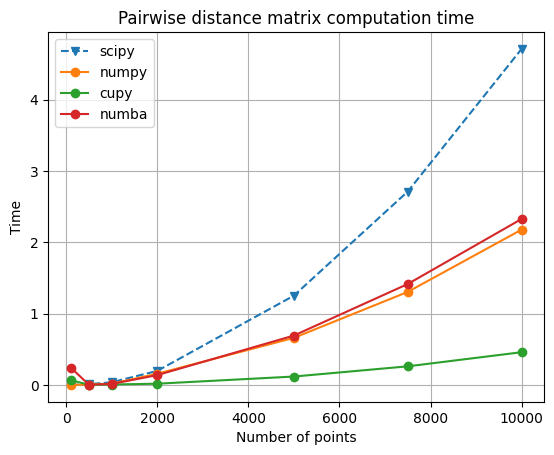

In [13]:
plt.plot(grid, scipy_times, label='scipy', marker='v', linestyle='--')
plt.plot(grid, numpy_times, label='numpy', marker='o')
plt.plot(grid, cupy_times, label='cupy', marker='o')
plt.plot(grid, numba_times, label='numba', marker='o')

plt.ylabel('Time')
plt.xlabel('Number of points')
plt.title('Pairwise distance matrix computation time')
plt.grid()
plt.legend()